## 1. Environment Creation

### 1.1 Library Import

In [1]:
''' FILE ACCESS '''

import json
import os
import glob
import smart_open

''' DATA QUERYING '''

import regex as re
import pandas as pd
import datetime
from datetime import datetime
from dateutil.parser import parse

''' THEMATIC ANALYSIS '''
from bertopic import BERTopic
#from transformers import AutoModel


''' TEXT PREPROCESSING '''
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
import regex as re

''' DATA VISUALIZATION '''

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Import

In [2]:
jan_sixth = pd.read_csv("Climate Posts January 6th.csv")
jan_twenty = pd.read_csv("Climate Posts January 20th.csv")

In [3]:
## Dropping the unneeded index files
jan_sixth.drop(columns=['Unnamed: 0'],inplace=True)
jan_twenty.drop(columns='Unnamed: 0',inplace=True)

In [4]:
'''Creating a macro date collection label
'''
## January 6th
six_list = []
for row in range(0,len(jan_sixth)):
    six_list.append("January 6th")
    
jan_sixth['date'] = six_list



## January 20th
twenty_list = []
for row in range(0,len(jan_twenty)):
    twenty_list.append("January 20th")
    
jan_twenty['date'] = twenty_list

### 2.1 Time Normalization

In [7]:
''' CONVERTING CREATED AT TIME TO TIMESTAMP'''
def time_converter(timestamp):
    dt = parse(timestamp)
    formatted_date_time = dt.strftime('%Y-%m-%d %H:%M')
    return (formatted_date_time)

In [8]:
## Applying the time_converter to the created_at time stamps
jan_sixth['datetime'] = jan_sixth['created_at'].apply(lambda x: time_converter(x))
jan_twenty['datetime'] = jan_twenty['created_at'].apply(lambda x: time_converter(x))

## Turning the string stampes into datetime stampes
jan_sixth['datetime'] = pd.to_datetime(jan_sixth['datetime'])
jan_twenty['datetime'] = pd.to_datetime(jan_twenty['datetime'])

### 2.2 Removing Numbers + Punctuation

In [9]:
def number_remover(text):
    new_text = re.sub("\d","",text)
    clean_text = re.sub("[.,?!#$%]","",new_text)
    return (clean_text)

In [11]:
jan_sixth['clean text'] = jan_sixth['text'].apply(lambda x: number_remover(x))
jan_twenty['clean text'] = jan_twenty['text'].apply(lambda x: number_remover(x))

### 2.3 Creating a corpus for January 6th and January 20th

In [13]:
corpus = pd.concat([jan_sixth,jan_twenty])

In [14]:
clean_posts = corpus['clean text'].to_list()

## 3. Dictionary Analysis

### 3.1 Dictionary Definition

The core themes of our dictionaries for this analysis are as follows: climate change, science, policy mangagement, Republican, Democrat, current politics (centered around our data collection dates), and current moment

The dictionaries from this section were inspired by the work completed in Molder & Calice and Chinn et al.

In [15]:
climate_change = ["global warming","climate change","greenhouse gas","greenhouse gases"]

policy_management = ["policy","legislation","FEMA","management","disaster respons",'government']

republican = ['republican','republicans','GOP','conservative','conservatives','MAGA']

democrat = ['democrat','democrats','liberal','liberals',"DNC"]

climate_action = ['climate activism','climate change legislation', 'climate change policy action','climate protest']

environmental_justice = ['environmental justice','climate justice','just transition','climate equity','climate equality']

climate_resilience = ['climate resilience','climate hope','climate communities','climate cafe']

In [16]:
word_list_nested = [climate_change,policy_management,republican,democrat,climate_action,environmental_justice,climate_resilience]

In [17]:
seed_topics = [climate_change,policy_management,republican,democrat,climate_action,environmental_justice,climate_resilience]

In [18]:
climate_words = []
for wl in word_list_nested:
    for word in wl:
        climate_words.append(word)

In [18]:
word_counter = {}

for word in climate_words:
    word_counter[word] = 0

In [19]:
word_counter

{'global warming': 0,
 'climate change': 0,
 'greenhouse gas': 0,
 'greenhouse gases': 0,
 'policy': 0,
 'legislation': 0,
 'FEMA': 0,
 'management': 0,
 'disaster respons': 0,
 'government': 0,
 'republican': 0,
 'republicans': 0,
 'GOP': 0,
 'conservative': 0,
 'conservatives': 0,
 'MAGA': 0,
 'democrat': 0,
 'democrats': 0,
 'liberal': 0,
 'liberals': 0,
 'DNC': 0,
 'climate activism': 0,
 'climate change legislation': 0,
 'climate change policy action': 0,
 'climate protest': 0,
 'environmental justice': 0,
 'climate justice': 0,
 'just transition': 0,
 'climate equity': 0,
 'climate equality': 0,
 'climate resilience': 0,
 'climate hope': 0,
 'climate communities': 0,
 'climate cafe': 0}

## 3. Topic Modeling

In [21]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english",decode_error='replace',strip_accents='ascii',
                                  lowercase=True)
topic_model = BERTopic(vectorizer_model=vectorizer_model,verbose=True,seed_topic_list=seed_topics)

In [ ]:
docs = corpus['clean text'].to_list()
  ## Using model.fit_transform, to apply to the list of documents. This will both embedd and assign topics to the texts in the document lists.
topics, probs = topic_model.fit_transform(docs)

In [25]:
cleaned_topics = topic_model.reduce_outliers(docs, topics)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.66it/s]


In [26]:
topic_model.update_topics(docs, topics=cleaned_topics)

2025-02-03 00:27:32,866 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [27]:
topic_info = topic_model.get_topic_info()

### 3.1 Saving the Model to HuggingFace

In [174]:
from huggingface_hub import login

In [ ]:
login()

In [176]:
topic_model.save("bsky-posts-political",serialization='pickle',save_embedding_model=True,save_ctfidf=True,)

2025-02-03 01:31:32,792 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
C:\Users\natal\miniconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:

# Push to HuggingFace Hub
topic_model.push_to_hf_hub(
    repo_id="nataliecastro/bsky-posts-political",
    save_ctfidf=True,
    private=True,
    commit_message='Adding January 6th and 20th climate related posts',
    save_embedding_model=True,
)


### 4.2 Identifying Semantically Related Topics

In [29]:
semantic_topics_nested = []
for word in climate_words:
    related_tuple = topic_model.find_topics(search_term=word)
    related_topics = related_tuple[0]
    
    semantic_topics_nested.append(related_topics)
    
semantic_topics = sum(semantic_topics_nested, [])

In [30]:
semantic_topics = list(set(semantic_topics))

In [31]:
len(semantic_topics)

52

In [33]:
climate_topic_info = []

for topic in semantic_topics:
    current_info = topic_model.get_topic_info(topic)
    climate_topic_info.append(current_info)
    
climate_topics = pd.concat(climate_topic_info)

In [34]:
semantic_topics_nested = []
for word in climate_words:
    related_tuple = topic_model.find_topics(search_term=word)
    related_topics = related_tuple[0]
    
    semantic_topics_nested.append(related_topics)
    
semantic_topics = sum(semantic_topics_nested, [])

In [35]:
labels = {}
for nest in range(0,len(semantic_topics_nested)):
    topic_nest = semantic_topics_nested[nest]
    related_word = climate_words[nest]
    
    labels[related_word] = topic_nest

In [36]:
labels

{'global warming': [69, 35, 4, 133, 0],
 'climate change': [69, 8, 47, 204, 4],
 'greenhouse gas': [4, 104, 13, 0, 126],
 'greenhouse gases': [4, 104, 13, 126, 22],
 'policy': [175, 164, 21, 116, 67],
 'legislation': [175, 210, 116, 136, 21],
 'FEMA': [65, 20, 29, 24, 175],
 'management': [109, 173, 168, 74, 15],
 'disaster respons': [29, 1, 159, 148, 18],
 'government': [116, 67, 29, 122, 175],
 'republican': [124, 33, 20, 67, 129],
 'republicans': [124, 33, 20, 67, 135],
 'GOP': [124, 33, 20, 135, 129],
 'conservative': [124, 33, 67, 129, 164],
 'conservatives': [124, 33, 19, 129, 67],
 'MAGA': [20, 124, 145, 87, 63],
 'democrat': [33, 124, 129, 20, 19],
 'democrats': [33, 124, 20, 135, 129],
 'liberal': [19, 124, 67, 33, 165],
 'liberals': [124, 33, 19, 165, 129],
 'DNC': [33, 124, 135, 19, 129],
 'climate activism': [21, 204, 4, 67, 104],
 'climate change legislation': [4, 13, 104, 15, 69],
 'climate change policy action': [21, 15, 13, 4, 204],
 'climate protest': [21, 4, 204, 104,

In [19]:
climate_change_topics = [69, 35, 4, 133, 0,8, 47, 204, 104, 13, 126,22]

policy_management_topics = [175, 164, 21, 116, 67, 210, 116, 136,65, 20, 29, 24,109, 173, 168, 74, 15, 29, 1, 159, 148, 18,122,]

republican_topics = [124, 33, 20, 129, 135,67, 164, 19,145,87,63]

democrat_topics = [33, 124, 129, 20, 19,135,67,165]

climate_action_topics = [21, 204, 4, 67, 13, 104, 15, 69, 47]

environmental_justice_topics = [12, 15, 13, 22, 37,4, 104, 204, 47, 8, 40, 182, 69, 35,162]

climate_resilience_topics = [1, 47, 15, 204, 58, 9, 104, 8,37,69, 6, 104, 4, 52, 187]

In [37]:
climate_topics = climate_topics.sort_values(by='Count',ascending=False)

In [39]:
climate_topics.to_csv("BlueSky Climate Topic List - Political Focusing Event.csv")

### 4.3 Matching Document To Topic

In [21]:
document_info = topic_model.get_document_info(clean_posts)

In [41]:
topic_filtered = []

for topic in semantic_topics:
    current_condition = document_info['Topic'] == topic
    current_documents = document_info[current_condition]
    
    topic_filtered.append(current_documents)
    
climate_document_info = pd.concat(topic_filtered)

In [43]:
topic_counts = climate_document_info['Name'].value_counts()

In [44]:
document_frequencies = pd.DataFrame(topic_counts)

In [45]:
document_frequencies['Percentage'] = document_frequencies['Name'].apply(lambda x: x/8194) 

In [46]:
document_frequencies.reset_index(inplace=True)

In [47]:
document_frequencies.rename(columns={"index":"Name","Name":"Frequnecy",},inplace=True)

In [48]:
name_and_topic = climate_document_info[['Topic','Name']].copy().drop_duplicates()

In [49]:
document_frequencies = document_frequencies.merge(right=name_and_topic,on='Name')

In [50]:
document_frequencies.head()

,Name,Frequnecy,Percentage,Topic
0,4_carbon_co_methane_emissions,3888,0.474494,4
1,0_energy_renewable_fossil_renewables,1912,0.233341,0
2,15_sustainability_sustainable_development_inno...,1841,0.224677,15
3,13_emissions_carbon_footprint_reduce,1465,0.178789,13
4,8_change_climate_about_crisis,1419,0.173175,8


### 4.4 Counting Instances Per Dictionary

In [274]:
def dictionary_filter(topic_dictionary):
    frequencies = []
    for topic in topic_dictionary:
        topic_condition = document_frequencies['Topic'] == topic
        
        current_frequency = document_frequencies[topic_condition]
        frequency = current_frequency.iloc[0,1]

        current_frequency = {"topic":topic,"frequency":frequency}
        
        frequencies.append(current_frequency)
        
    return (pd.DataFrame(frequencies))

In [275]:
''' COPIED FROM ABOVE'''
climate_change_topics = [69, 35, 4, 133, 0,8, 47, 204, 104, 13, 126,22]

policy_management_topics = [175, 164, 21, 116, 67, 210, 116, 136,65, 20, 29, 24,109, 173, 168, 74, 15, 29, 1, 159, 148, 18,122,]

republican_topics = [124, 33, 20, 129, 135,67, 164, 19,145,87,63]

democrat_topics = [33, 124, 129, 20, 19,135,67,165]

climate_action_topics = [21, 204, 4, 67, 13, 104, 15, 69, 47]

environmental_justice_topics = [12, 15, 13, 22, 37,4, 104, 204, 47, 8, 40, 182, 69, 35,162]

climate_resilience_topics = [1, 47, 15, 204, 58, 9, 104, 8,37,69, 6, 104, 4, 52, 187]

In [276]:
climate_change_freqs = dictionary_filter(climate_change_topics)
policy_freqs = dictionary_filter(policy_management_topics)
republican_freqs = dictionary_filter(republican_topics)
democrat_freqs = dictionary_filter(democrat_topics)
ca_freqs = dictionary_filter(climate_action_topics)
ej_freqs = dictionary_filter(environmental_justice_topics)
cr_freqs = dictionary_filter(climate_resilience_topics)

frequencies = [climate_change_freqs,
policy_freqs,
republican_freqs,
democrat_freqs,
ca_freqs,
ej_freqs,
cr_freqs,]

In [277]:
dictionary_names = ["Climate\nChange",'Policy\nManagement','Republican','Democrat','Climate\nAction','Environmental\nJustice','Climate\nResilience']

In [278]:
dictionary_values = []
for i in range(0,len(dictionary_names)):
    current_dictionary = dictionary_names[i]
    
    current_freq = frequencies[i]
    desc = current_freq.describe()
    mean = desc.iloc[1,1]
    min_ = desc.iloc[3,1]
    max_ = desc.iloc[7,1]
    freq = current_freq['frequency'].sum()
    
    dictionary_topic_info = {"Dictionary":current_dictionary,"Total Frequency":freq,
                            "Average Topic Size":mean,"Maximum Topic Size":max_,"Minimum Topic Size":min_}
    
    dictionary_values.append(dictionary_topic_info)
    
    print (current_dictionary,"-----------------")
    print (f"Total Frequency: {freq}\nMean: {mean}\nMin: {min_}\nMax: {max_}\n")

Climate
Change -----------------
Total Frequency: 12329
Mean: 1027.4166666666667
Min: 31.0
Max: 3888.0

Policy
Management -----------------
Total Frequency: 8349
Mean: 363.0
Min: 17.0
Max: 1841.0

Republican -----------------
Total Frequency: 5360
Mean: 487.27272727272725
Min: 34.0
Max: 1218.0

Democrat -----------------
Total Frequency: 5245
Mean: 655.625
Min: 86.0
Max: 1218.0

Climate
Action -----------------
Total Frequency: 11976
Mean: 1330.6666666666667
Min: 280.0
Max: 3888.0

Environmental
Justice -----------------
Total Frequency: 12971
Mean: 864.7333333333333
Min: 23.0
Max: 3888.0

Climate
Resilience -----------------
Total Frequency: 12809
Mean: 853.9333333333333
Min: 27.0
Max: 3888.0



In [279]:
values = pd.DataFrame(dictionary_values).sort_values(by='Total Frequency',ascending=False)
values 

,Dictionary,Total Frequency,Average Topic Size,Maximum Topic Size,Minimum Topic Size
5,Environmental\nJustice,12971,864.733333,3888.0,23.0
6,Climate\nResilience,12809,853.933333,3888.0,27.0
0,Climate\nChange,12329,1027.416667,3888.0,31.0
4,Climate\nAction,11976,1330.666667,3888.0,280.0
1,Policy\nManagement,8349,363.000000,1841.0,17.0
2,Republican,5360,487.272727,1218.0,34.0
3,Democrat,5245,655.625000,1218.0,86.0


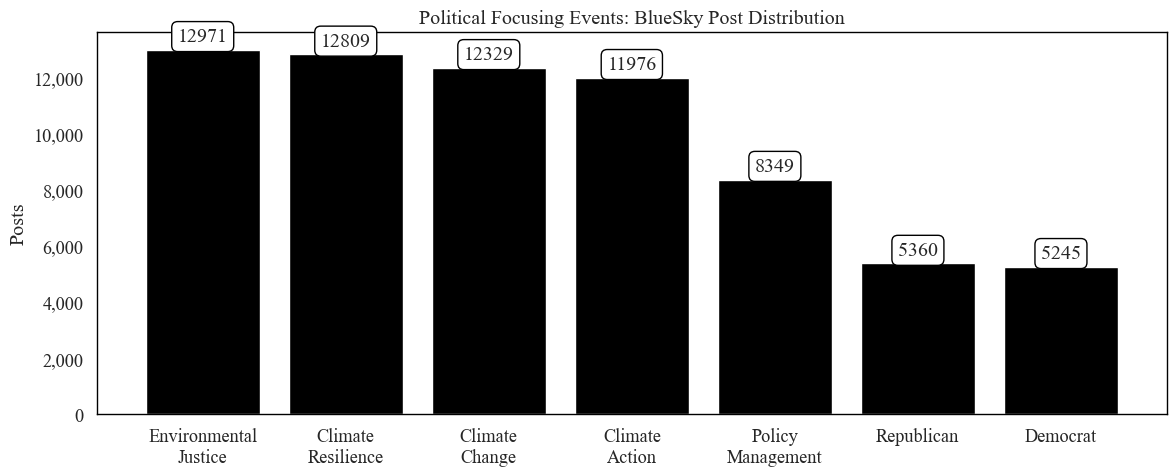

In [78]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)
fig, ax = plt.subplots(figsize=(12,5 )) 



hist = sb.barplot(values,x="Dictionary",y="Total Frequency",color="black")


for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)
    
    for center, height in zip(centers, heights):
        plt.text(
            center, 
            height, 
            f'{int(height):,}',  # Format with commas
            color='black', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

hist.set_title("Political Focusing Events: BlueSky Post Distribution")
hist.set_xlabel("")
hist.set_ylabel("Posts")
ax.tick_params(axis='x')
ax.grid(True)
ax.set_facecolor("white")

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)


# Set the border (box) around the entire plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the color of the border to black
    spine.set_linewidth(1)  # Set the width of the border

plt.tight_layout()
plt.savefig("Political Focusing Events- BlueSky Post Distribution.png",dpi=2500)
plt.show();

### 4.5 Visualizing the Top N Most Frequent Terms for Climate Policy Dictionary

In [ ]:
topic_model = BERTopic.load("nataliecastro/bsky-posts-political")

In [23]:
''' PARSING THROUGH THE DATAFRAME TO MAKE A LIST OF ALL OF THE DOCUMENTS THAT ARE IN POLICY MANAGEMENT '''

policy_documents =document_info[document_info['Topic'].isin(policy_management_topics)]
policy_documents.reset_index(inplace=True)
policy_documents.drop(columns='index',inplace=True)

In [24]:
topn_words = policy_documents['Document'].to_list()

In [25]:
joined_list = ' '.join(topn_words)
policy_words = joined_list.split(" ")

In [26]:
## Removing stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

stop_words.update(["the","like","it"])

## Stemming the words so morphemes are counted together
from nltk.stem import PorterStemmer
ps = PorterStemmer()

stemmed_words = []
for word in policy_words:
    if word not in stop_words:
        if word != "":
            if word != "&":
                if word != "-":
                    stem = ps.stem(word)

                    stemmed_words.append(stem)

In [27]:
from collections import Counter

c = Counter(stemmed_words)

In [28]:
policy_wcs = pd.DataFrame(c.items(), columns=['Word', 'Count'])

In [29]:
policy_wcs.sort_values(by='Count',ascending=False,inplace=True)
policy_data = policy_wcs.head(30)

In [31]:
policy_data.reset_index(inplace=True)

In [35]:
policy_data.drop(index=[24,29],inplace=True)

In [36]:
policy_data

,index,Word,Count
0,31,climat,907
1,103,i,634
2,181,resili,501
4,575,trump,302
5,156,us,284
6,90,earth,274
7,136,chang,256
8,145,sustain,249
9,227,peopl,238
10,60,earthquak,198


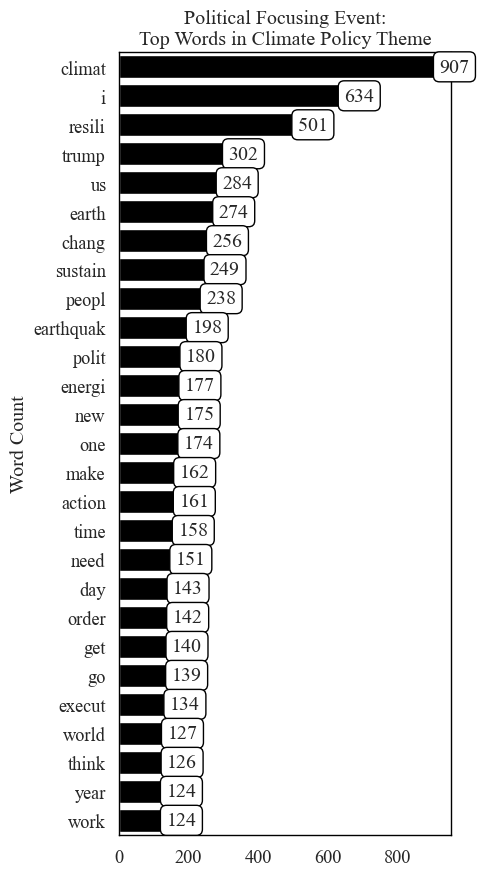

In [37]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)
fig, ax = plt.subplots(figsize=(5,9 )) 



hist = sb.barplot(policy_data,x="Count",y="Word",color="black")


'''for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)
    
    for center, height in zip(centers, heights):
        plt.text(
            center, 
            height, 
            f'{int(height):,}',  # Format with commas
            color='black', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
'''

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
hist.set_title("Political Focusing Event:\nTop Words in Climate Policy Theme")
hist.set_xlabel("")
hist.set_ylabel("Word Count")
ax.tick_params(axis='x')
ax.grid(True)
ax.set_facecolor("white")

'''formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)'''


# Set the border (box) around the entire plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the color of the border to black
    spine.set_linewidth(1)  # Set the width of the border

plt.tight_layout()
plt.savefig("Political Focusing Events- Top Words in Climate Policy Theme.png",dpi=2500)
plt.show();

## 5. Fitting the News Documents Into The Corpus

In [240]:
## Data Import
## News Headlines 
headlines_6 = pd.read_excel("Climate Headlines - January 6th.xlsx")
headlines_20 = pd.read_csv("Climate Headlines - January 20th.csv")

In [241]:
headlines = pd.concat([headlines_6,headlines_20])

In [242]:
headlines.drop(columns='Unnamed: 0',inplace=True)

In [243]:
headlines['clean text'] = headlines['headline clean'].apply(lambda x: number_remover(x))
headlines.drop_duplicates(subset='clean text',inplace=True)
news = headlines['clean text'].to_list()

In [245]:
print (len(news))

200


In [246]:
''' 200 HEADLINES FROM JAN 6 & JAN 20 THAT ARE NOT DUPLICATES'''

' 200 HEADLINES FROM JAN 6 & JAN 20 THAT ARE NOT DUPLICATES'

In [247]:
probable_news_topics = []
for headline in news:
    current_topic, similarity = topic_model.find_topics(headline,top_n=1)
    probable_news_topics.append(current_topic[0])

In [248]:
news_topics

,Headline,Topic,Name
0,"<i class=""css-qtgz""></i><span aria-hidden=""tru...",76,76_httpsearthquaketenkijpbousaiearthquakedetai...
1,Human composting is rising in popularity as an...,51,51_soil_farmers_agriculture_food
2,IIT Bombay develops bacteria to combat soil po...,51,51_soil_farmers_agriculture_food
3,Could an IVF calf help reduce dairy’s global e...,51,51_soil_farmers_agriculture_food
4,Could an IVF calf help reduce dairy's global e...,51,51_soil_farmers_agriculture_food
...,...,...,...
212,"<img alt="""" class=""gnt_m_flm_i"" data-g-r=""lazy...",35,35_warming_up_cold_my
213,Day One: Trump signs executive orders on clima...,109,109_executive_orders_immigration_sign
214,Trump pardons nearly people over Capitol riot...,74,74_pardons_rioters_exits_slew
215,Trump pardons January rioters and ditches cli...,74,74_pardons_rioters_exits_slew


In [249]:
''' CREATING THE DATAFRAME '''
news_topics = pd.DataFrame()
news_topics['Headline'] = news
news_topics['Topic'] = probable_news_topics

In [250]:
''' FINDING THE TOPIC NAMES'''
topic_info = topic_model.get_topic_info()
topic_names = topic_info[['Topic','Name']]

In [251]:
''' MERGING TOPIC NAMES TO NEWS HEADLINES '''
news_topics = news_topics.merge(right=topic_names,on='Topic')

In [252]:
value_counts = pd.DataFrame(news_topics.value_counts("Name"))

In [253]:
## Fixing the indices
value_counts.reset_index(inplace=True)

In [254]:
value_counts.rename(columns={"Name":"Name",0:"Frequency"},inplace=True)

In [255]:
value_counts['Percentage'] = value_counts['Frequency'] / 200 ## value here is generated based on the 

In [256]:
value_counts

,Name,Frequency,Percentage
0,148_earthquake_nhk_just_in,23,0.115
1,2_tibet_earthquake_nepal_least,11,0.055
2,73_deforestation_forest_amazon_forests,11,0.055
3,32_paris_agreement_withdrawal_accords,11,0.055
4,13_emissions_carbon_footprint_reduce,10,0.050
5,204_climatereality_joining_algore_crisis,9,0.045
6,7_paris_agreement_trump_withdraw,9,0.045
7,15_sustainability_sustainable_development_inno...,9,0.045
8,4_carbon_co_methane_emissions,9,0.045
9,0_energy_renewable_fossil_renewables,8,0.040


In [257]:
def topic_num(topic_name):
    pattern = r"[0-9]{1,3}"
    
    found = re.findall(pattern,topic_name)
    string_found = found[0]
    int_found = int(string_found)
    return (int_found)

In [258]:
value_counts['Topic'] = value_counts['Name'].apply(lambda x: topic_num(x))

In [259]:
def dictionary_filter(topic_dictionary):
    frequencies = []
    for topic in topic_dictionary:
        topic_condition = value_counts['Topic'] == topic
        
        current_frequency = value_counts[topic_condition]
        if len(current_frequency) != 0:
            frequency = current_frequency.iloc[0,1]

            current_frequency = {"topic":topic,"frequency":frequency}
           
        else:
            current_frequency = {"topic":topic,"frequency":0}
            
            
        frequencies.append(current_frequency)
        
    return (pd.DataFrame(frequencies))

In [260]:
climate_change_freqs = dictionary_filter(climate_change_topics)
policy_freqs = dictionary_filter(policy_management_topics)
republican_freqs = dictionary_filter(republican_topics)
democrat_freqs = dictionary_filter(democrat_topics)
ca_freqs = dictionary_filter(climate_action_topics)
ej_freqs = dictionary_filter(environmental_justice_topics)
cr_freqs = dictionary_filter(climate_resilience_topics)

frequencies = [climate_change_freqs,
policy_freqs,
republican_freqs,
democrat_freqs,
ca_freqs,
ej_freqs,
cr_freqs,]

In [261]:
dictionary_values = []
for i in range(0,len(dictionary_names)):
    current_dictionary = dictionary_names[i]
    
    current_freq = frequencies[i]
    desc = current_freq.describe()
    mean = desc.iloc[1,1]
    min_ = desc.iloc[3,1]
    max_ = desc.iloc[7,1]
    freq = current_freq['frequency'].sum()
    
    dictionary_topic_info = {"Dictionary":current_dictionary,"Total Frequency":freq,
                            "Average Topic Size":mean,"Maximum Topic Size":max_,"Minimum Topic Size":min_}
    
    dictionary_values.append(dictionary_topic_info)
    
    print (current_dictionary,"-----------------")
    print (f"Total Frequency: {freq}\nMean: {mean}\nMin: {min_}\nMax: {max_}\n")

Climate
Change -----------------
Total Frequency: 65
Mean: 5.416666666666667
Min: 0.0
Max: 10.0

Policy
Management -----------------
Total Frequency: 53
Mean: 2.3043478260869565
Min: 0.0
Max: 23.0

Republican -----------------
Total Frequency: 3
Mean: 0.2727272727272727
Min: 0.0
Max: 1.0

Democrat -----------------
Total Frequency: 1
Mean: 0.125
Min: 0.0
Max: 1.0

Climate
Action -----------------
Total Frequency: 60
Mean: 6.666666666666667
Min: 0.0
Max: 10.0

Environmental
Justice -----------------
Total Frequency: 66
Mean: 4.4
Min: 0.0
Max: 10.0

Climate
Resilience -----------------
Total Frequency: 62
Mean: 4.133333333333334
Min: 0.0
Max: 9.0



In [262]:
values = pd.DataFrame(dictionary_values).sort_values(by='Total Frequency',ascending=False)
values 

,Dictionary,Total Frequency,Average Topic Size,Maximum Topic Size,Minimum Topic Size
5,Environmental\nJustice,66,4.400000,10.0,0.0
0,Climate\nChange,65,5.416667,10.0,0.0
6,Climate\nResilience,62,4.133333,9.0,0.0
4,Climate\nAction,60,6.666667,10.0,0.0
1,Policy\nManagement,53,2.304348,23.0,0.0
2,Republican,3,0.272727,1.0,0.0
3,Democrat,1,0.125000,1.0,0.0


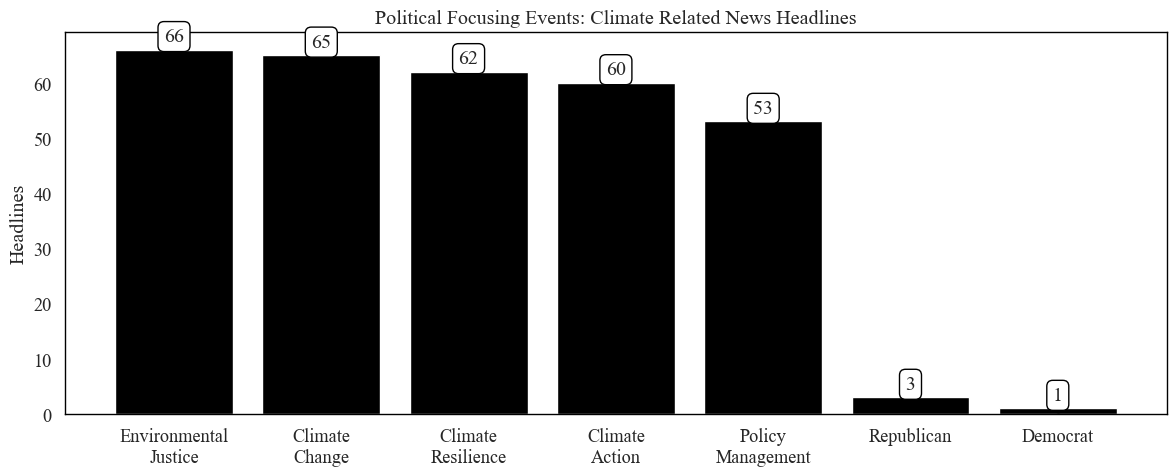

In [263]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)
fig, ax = plt.subplots(figsize=(12,5 )) 



hist = sb.barplot(values,x="Dictionary",y="Total Frequency",color="black")


for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)
    
    for center, height in zip(centers, heights):
        plt.text(
            center, 
            height, 
            f'{int(height):,}',  # Format with commas
            color='black', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

hist.set_title("Political Focusing Events: Climate Related News Headlines")
hist.set_xlabel("")
hist.set_ylabel("Headlines")
ax.tick_params(axis='x')
ax.grid(True)
ax.set_facecolor("white")

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)


# Set the border (box) around the entire plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the color of the border to black
    spine.set_linewidth(1)  # Set the width of the border

plt.tight_layout()
plt.savefig("Political Focusing Events - Climate Related News Headlines.png",dpi=2500)
plt.show();

## 6. Creating A Word Cloud Based on The Documents

In [265]:
post_text = " ".join(clean_posts)
headline_text = " ".join(news)

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

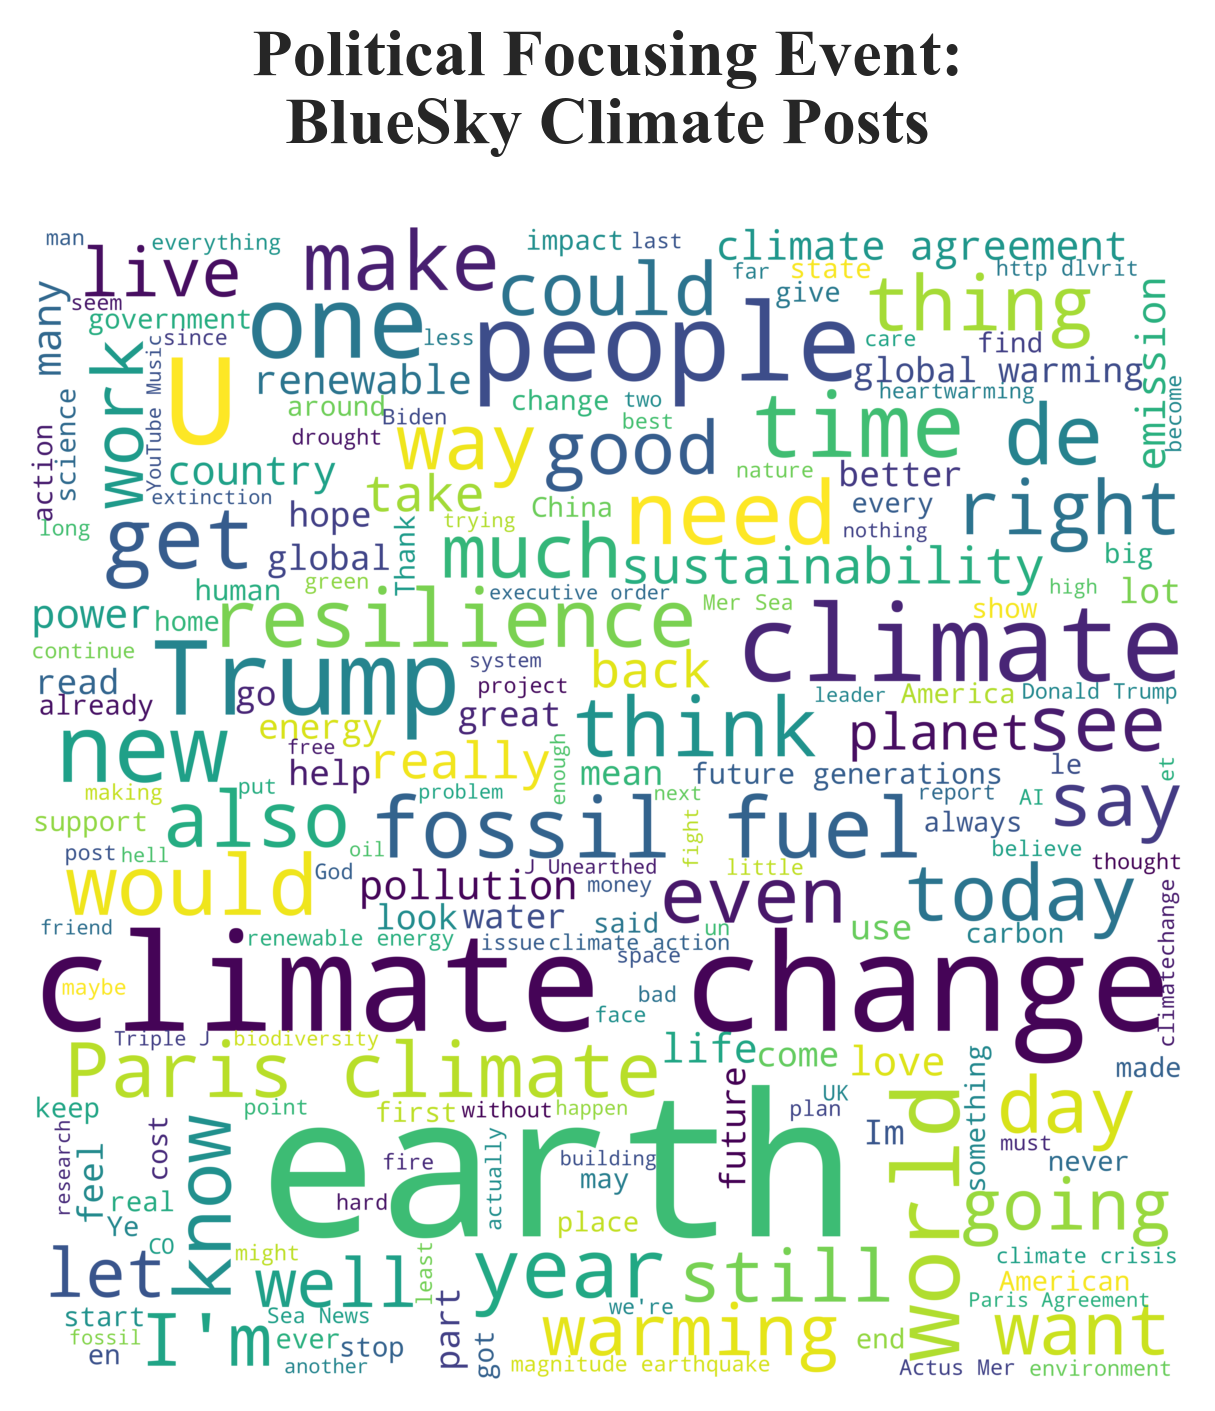

In [266]:

# Create an elliptical mask
x, y = np.ogrid[:800, :800]
mask = (x - 400)**2 / 2**2 + (y - 400)**2 / 1.5**2 > 380**2  # Creates an oval shape
mask = mask.astype(int)  # Convert to 0s and 1s

# Create a WordCloud object with stopwords, title, and oval shape
wordcloud = WordCloud(
    width=2000,
    height=1000,
    background_color='white',
    colormap='viridis',
    stopwords=stop_words,
    mask=mask,
    scale=10
).generate(post_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.title("Political Focusing Event:\nBlueSky Climate Posts", fontsize=16, fontweight='bold', pad=20)  # Add title
plt.show()


wordcloud.to_file("Political Focusing Event - Climate Post Word Cloud.png")

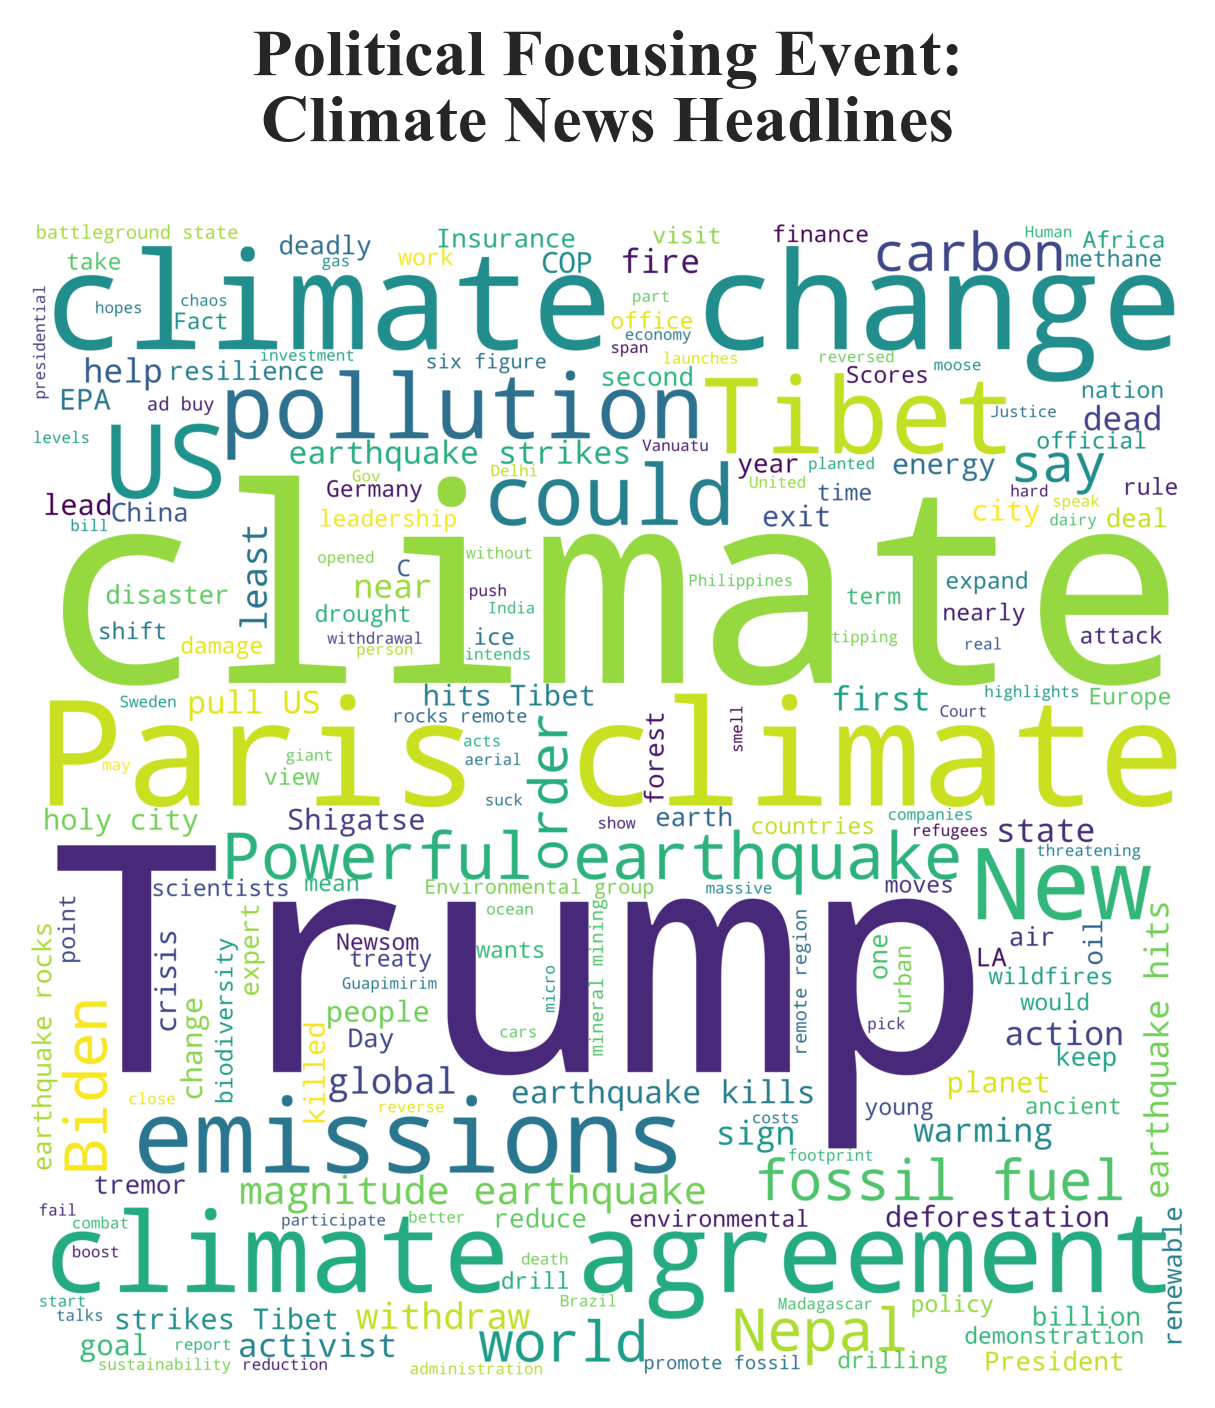

In [267]:

# Create an elliptical mask
x, y = np.ogrid[:800, :800]
mask = (x - 400)**2 / 2**2 + (y - 400)**2 / 1.5**2 > 380**2  # Creates an oval shape
mask = mask.astype(int)  # Convert to 0s and 1s

# Create a WordCloud object with stopwords, title, and oval shape
wordcloud = WordCloud(
    width=2000,
    height=1000,
    background_color='white',
    colormap='viridis',
    stopwords=stop_words,
    mask=mask,
    scale=10
).generate(headline_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.title("Political Focusing Event:\nClimate News Headlines", fontsize=16, fontweight='bold', pad=20)  # Add title
plt.show()


wordcloud.to_file("Political Focusing Event - Climate News Headlines Word Cloud.png")

## 7. Calculating Table Values

In [273]:
values ## For Newspaper

,Dictionary,Total Frequency,Average Topic Size,Maximum Topic Size,Minimum Topic Size,perc
5,Environmental\nJustice,66,4.400000,10.0,0.0,33.0
0,Climate\nChange,65,5.416667,10.0,0.0,32.5
6,Climate\nResilience,62,4.133333,9.0,0.0,31.0
4,Climate\nAction,60,6.666667,10.0,0.0,30.0
1,Policy\nManagement,53,2.304348,23.0,0.0,26.5
2,Republican,3,0.272727,1.0,0.0,1.5
3,Democrat,1,0.125000,1.0,0.0,0.5


In [272]:
values['perc'] = (values['Total Frequency'] / 200)*100

In [288]:
values ## For Posts

,Dictionary,Total Frequency,Average Topic Size,Maximum Topic Size,Minimum Topic Size,perc
5,Environmental\nJustice,12971,864.733333,3888.0,23.0,66.95
6,Climate\nResilience,12809,853.933333,3888.0,27.0,66.11
0,Climate\nChange,12329,1027.416667,3888.0,31.0,63.63
4,Climate\nAction,11976,1330.666667,3888.0,280.0,61.81
1,Policy\nManagement,8349,363.000000,1841.0,17.0,43.09
2,Republican,5360,487.272727,1218.0,34.0,27.66
3,Democrat,5245,655.625000,1218.0,86.0,27.07


In [287]:
values['perc'] = round((values['Total Frequency'] / 19375)*100,2)

In [282]:
len(clean_posts)

19375